In [1]:
!pip install nltk

In [88]:
!pip install mlxtend

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ----- ---------------------------------- 0.2/1.4 MB 4.1 MB/s eta 0:00:01
   ---------------- ----------------------- 0.6/1.4 MB 6.2 MB/s eta 0:00:01
   ------------------------- -------------- 0.9/1.4 MB 5.8 MB/s eta 0:00:01
   --------------------------------- ------ 1.2/1.4 MB 6.0 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.4 MB 5.7 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 5.8 MB/s eta 0:00:00


In [2]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import tensorflow as tf
import pandas as pd

from gensim.models.keyedvectors import KeyedVectors
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
embedding_file = './GoogleNews-vectors-negative300.bin.gz'

In [4]:
word_vectors = KeyedVectors.load_word2vec_format(embedding_file, binary=True, limit=200000)

In [5]:
df = pd.read_csv("E:\Datasets\labeled_data.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,text
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [6]:
df = df.rename(columns={'tweet': 'text'})
df = df.rename(columns={'class': 'label'})

df['label'] = df['label'].replace(0, 1)
df['label'] = df['label'].replace(2, 0)
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,label,text
0,0,3,0,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy

nlp = spacy.load("en_core_web_sm")

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
def remove_punctuation(tweet):
    tweet = tweet.lower()
    return tweet.translate(str.maketrans('', '', string.punctuation))

def preprocess_tweet(tweet):
    tokens = word_tokenize(tweet)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return ' '.join(lemmatized_tokens)

def remove_non_content_words(text):
    doc = nlp(text)
    clean_text = ' '.join([token.text for token in doc if token.pos_ not in ['ADP','CCONJ' 'DET']])
    return clean_text

def remove_entities(text):
    doc = nlp(text)
#     'PERSON', 'ORG', 'DATE', 'TIME', 'MONEY'
    clean_text = ' '.join([token.text for token in doc if token.ent_type_ not in ['DATE', 'TIME', 'MONEY','GPE','ORDINAL','QUANTITY']])
    return clean_text

df['text'] = df['text'].apply(remove_punctuation)
df['text'] = df['text'].apply(preprocess_tweet)
df['text'] = df['text'].apply(lambda x: remove_entities(x))
df['text'] = df['text'].apply(lambda x: remove_non_content_words(x))

df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,label,text
0,0,3,0,0,3,0,rt mayasolovely woman should nt complain clean...
1,1,3,0,3,0,1,rt mleew17 boy dat coldtyga dwn bad cuffin dat...
2,2,3,0,3,0,1,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,3,3,0,2,1,1,rt cganderson vivabased look tranny
4,4,6,0,6,0,1,rt shenikaroberts shit hear might true might f...


In [9]:
def get_unique_words(text):
    words = text.split()  
    unique_words = set(words)  
    return unique_words 

unique_words_set = set()
df['text'].apply(lambda x: unique_words_set.update(get_unique_words(x)))


unique_words_list = list(unique_words_set)

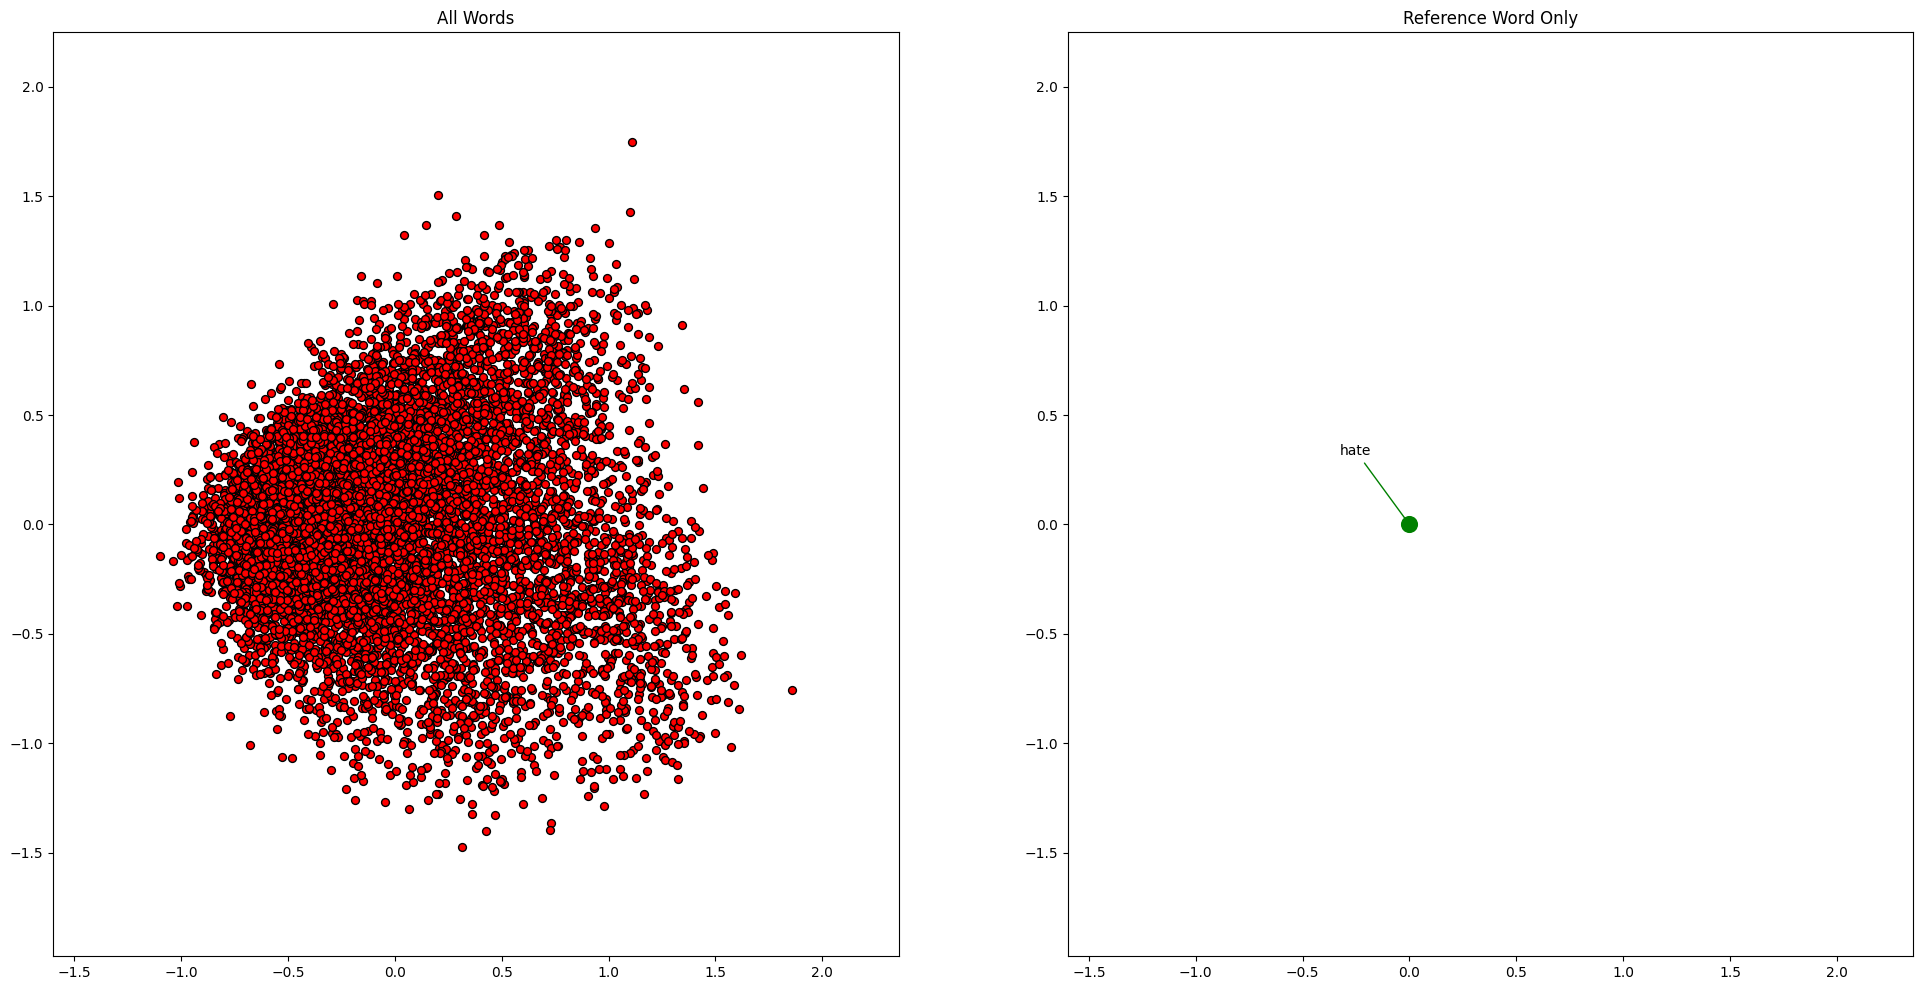

In [10]:
def display_pca_scatterplot(model, words):        
    word_vectors = []
    reference_word = "hate"  # Reference word

    for w in words:
        try:
            vector = model[w]
            word_vectors.append((w, vector))  # Collect all word vectors including the reference word
        except KeyError:
            pass

    word_vectors = np.array([vec for _, vec in word_vectors])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))  # Create subplots

    # Plot all word vectors in the first subplot
    ax1.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r', s=32)  # Reduce the size of dots
    ax1.set_title('All Words')

    # Mark reference word as green and draw a label line to it from the origin in the first subplot
    for word, (x, y) in zip(words, twodim):
        if word == reference_word:
            ax1.scatter(x, y, color='g', s=128)
            ax1.plot([0, x], [0, y], color='g', linestyle='--')  # Draw a line from origin to the word "hate"
            ax1.annotate(word, xy=(x, y), xytext=(-50, 50), textcoords='offset points',
                         arrowprops=dict(arrowstyle='-', color='g', connectionstyle="arc3,rad=0"))
    ax1.set_xlim(twodim[:,0].min() - 0.5, twodim[:,0].max() + 0.5)  # Set x-axis limits
    ax1.set_ylim(twodim[:,1].min() - 0.5, twodim[:,1].max() + 0.5)  # Set y-axis limits

    # Plot only the reference word in the second subplot
    ax2.scatter(0, 0, color='g', s=128)  # Plot the reference word at the origin
    ax2.annotate(reference_word, xy=(0, 0), xytext=(-50, 50), textcoords='offset points',
                 arrowprops=dict(arrowstyle='-', color='g', connectionstyle="arc3,rad=0"))
    ax2.set_title('Reference Word Only')
    ax2.set_xlim(twodim[:,0].min() - 0.5, twodim[:,0].max() + 0.5)  # Set x-axis limits
    ax2.set_ylim(twodim[:,1].min() - 0.5, twodim[:,1].max() + 0.5)  # Set y-axis limits

    plt.show()

display_pca_scatterplot(word_vectors, unique_words_list)

In [11]:
word_vectors = KeyedVectors.load_word2vec_format(embedding_file, binary=True, limit=1000000)

In [12]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=20000,
                                               filters='0123456789!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                                               lower=True)

In [13]:
from sklearn.model_selection import train_test_split

X = df["text"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

tokenizer.fit_on_texts(X_train)
MAX_REVIEW_LEN = 200
X_train = tokenizer.texts_to_sequences(X_train)
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_REVIEW_LEN)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_REVIEW_LEN)

num_tokens = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word_vectors.has_index_for(word):
        embedding_matrix[i] = word_vectors[word].copy()

embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_REVIEW_LEN,
    trainable=True
)

model = keras.Sequential()
model.add(embedding_layer)
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_test, y_test), callbacks=[es_callback])

Training set shape: (19826,) (19826,)
Testing set shape: (4957,) (4957,)
Epoch 1/20
39/39 [==============================] - 2s 25ms/step - loss: 0.5120 - accuracy: 0.8319 - val_loss: 0.4501 - val_accuracy: 0.8316
Epoch 2/20
39/39 [==============================] - 1s 16ms/step - loss: 0.4388 - accuracy: 0.8321 - val_loss: 0.4327 - val_accuracy: 0.8316
Epoch 3/20
39/39 [==============================] - 1s 17ms/step - loss: 0.4132 - accuracy: 0.8321 - val_loss: 0.3896 - val_accuracy: 0.8316
Epoch 4/20
39/39 [==============================] - 1s 16ms/step - loss: 0.3158 - accuracy: 0.8467 - val_loss: 0.2495 - val_accuracy: 0.8957
Epoch 5/20
39/39 [==============================] - 1s 16ms/step - loss: 0.1608 - accuracy: 0.9446 - val_loss: 0.1601 - val_accuracy: 0.9385
Epoch 6/20
39/39 [==============================] - 1s 16ms/step - loss: 0.0893 - accuracy: 0.9681 - val_loss: 0.1482 - val_accuracy: 0.9419
Epoch 7/20
39/39 [==============================] - 1s 16ms/step - loss: 0.0638 -

In [81]:
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')


155/155 [==============================] - 1s 3ms/step - loss: 0.1727 - accuracy: 0.9401
Test results - Loss: 0.17266808450222015 - Accuracy: 94.00847554206848%


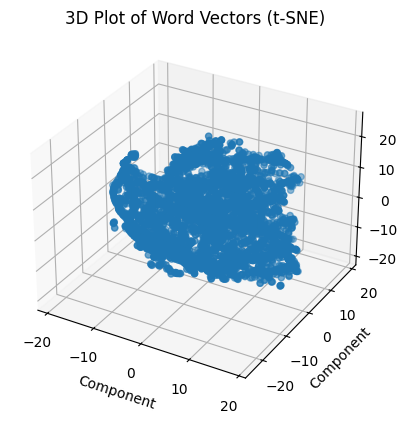

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

# Assuming word_vectors is a numpy array of shape (num_words, 200)
word_vectors = np.random.randn(100, 200)  # Example random word vectors

# Perform t-SNE to reduce dimensionality to 3
tsne = TSNE(n_components=3, random_state=42)
word_vectors_3d_tsne = tsne.fit_transform(X_test)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot word vectors
ax.scatter(word_vectors_3d_tsne[:, 0], word_vectors_3d_tsne[:, 1], word_vectors_3d_tsne[:, 2])

# Set labels and title
ax.set_xlabel('Component')
ax.set_ylabel('Component')
ax.set_zlabel('Component')
ax.set_title('3D Plot of Word Vectors (t-SNE)')

# Show plot
plt.show()


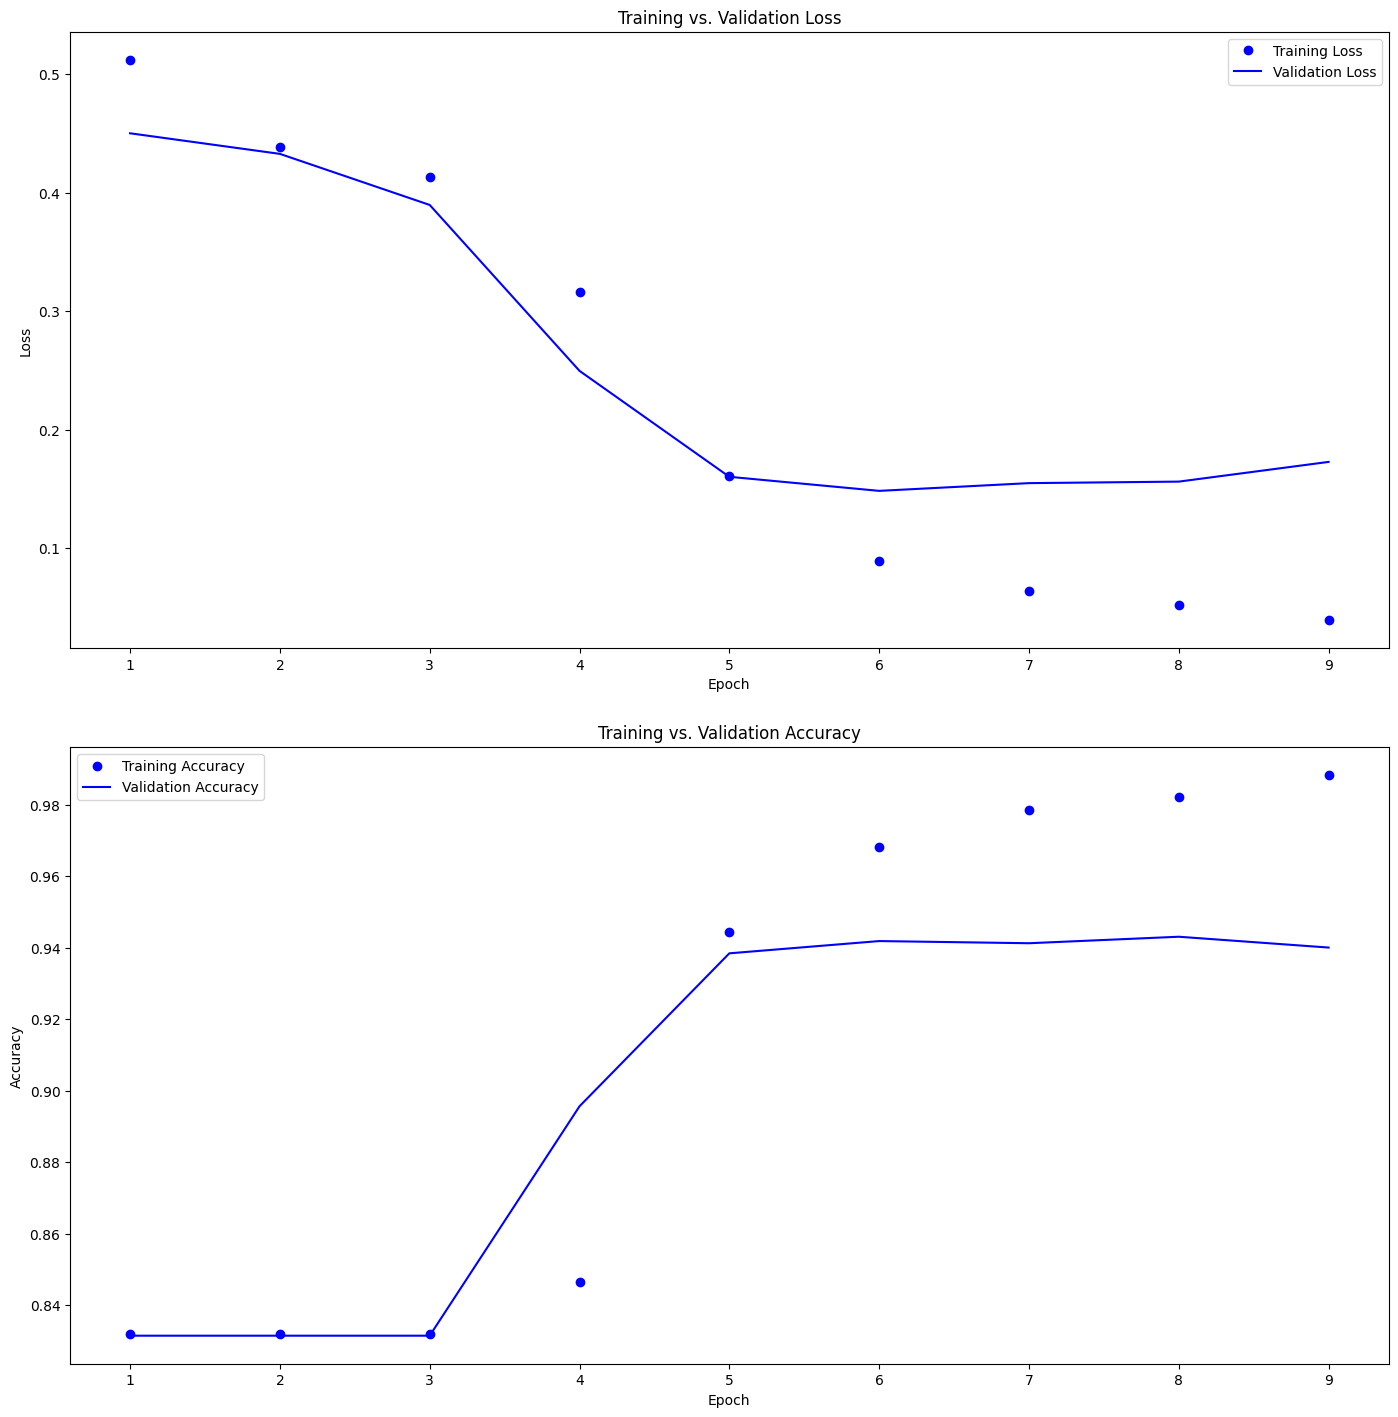

In [114]:
def plot_train_vs_val_performance(history):
  training_losses = history.history['loss']
  validation_losses = history.history['val_loss']

  training_accuracy = history.history['accuracy']
  validation_accuracy = history.history['val_accuracy']

  epochs = range(1, len(training_losses) + 1)

  import matplotlib.pyplot as plt
  fig, (ax1, ax2) = plt.subplots(2)
  fig.set_figheight(15)
  fig.set_figwidth(15)
  fig.tight_layout(pad=5.0)

  # Plot training vs. validation loss.
  ax1.plot(epochs, training_losses, 'bo', label='Training Loss')
  ax1.plot(epochs, validation_losses, 'b', label='Validation Loss')
  ax1.title.set_text('Training vs. Validation Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()

  # PLot training vs. validation accuracy.
  ax2.plot(epochs, training_accuracy, 'bo', label='Training Accuracy')
  ax2.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
  ax2.title.set_text('Training vs. Validation Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  plt.show()
plot_train_vs_val_performance(history)

In [47]:
def sentiment(reviews):
  seqs = tokenizer.texts_to_sequences(reviews)
  seqs = keras.preprocessing.sequence.pad_sequences(seqs, maxlen=MAX_REVIEW_LEN)
  return model.predict(seqs)
review = "this is the best cafe"
print(sentiment([review]))

1/1 [==============================] - 0s 7ms/step
[[0.32811302]]


In [74]:
from sklearn.metrics import f1_score

# Predict probabilities for the validation set
probabilities = model.predict(X_test)

# Define a range of threshold values
thresholds = np.arange(0.1, 1.0, 0.05)

# Initialize variables to store F1-scores and corresponding thresholds
best_f1_score = 0
optimal_threshold = 0

# Iterate over each threshold value
for threshold in thresholds:
    # Convert probabilities to binary predictions using the threshold
    binary_predictions = (probabilities >= threshold).astype(int)
    
    # Calculate F1-score
    f1 = f1_score(y_test, binary_predictions)
    
    # Update best F1-score and corresponding threshold if a new maximum is found
    if f1 > best_f1_score:
        best_f1_score = f1
        optimal_threshold = threshold

print("Optimal Threshold:", optimal_threshold)
print("Best F1-score:", best_f1_score)

155/155 [==============================] - 0s 2ms/step
Optimal Threshold: 0.7000000000000002
Best F1-score: 0.9656678393788669


In [65]:
new_data = pd.read_csv("E:\Datasets\English_test.csv")

new_data["text"] = new_data["text"].apply(remove_punctuation)
new_data["text"] = new_data["text"].apply(preprocess_tweet)
new_data["text"] = new_data["text"].apply(lambda x: remove_entities(x))
new_data["text"] = new_data["text"].apply(lambda x: remove_non_content_words(x))

X_new = new_data["text"]
y_new = new_data["label"]



X_new.head()

0    rt warreports 8 pakistani irgc zeynabiun briga...
1                   gronk tide pod commercial retarded
2    sfrantzman pmakela1 found lot weapon wwii gun ...
3    pakistani taliban announcement support isi lin...
4       good luck getting attention week isi pokemongo
Name: text, dtype: object

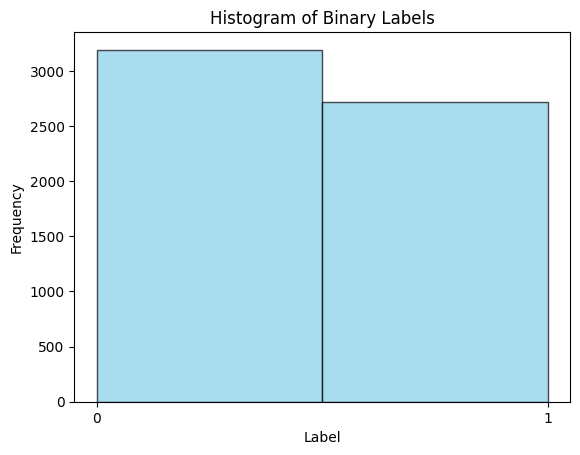

In [80]:
plt.hist(new_data["label"], bins=2, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Binary Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([0, 1])
plt.show()

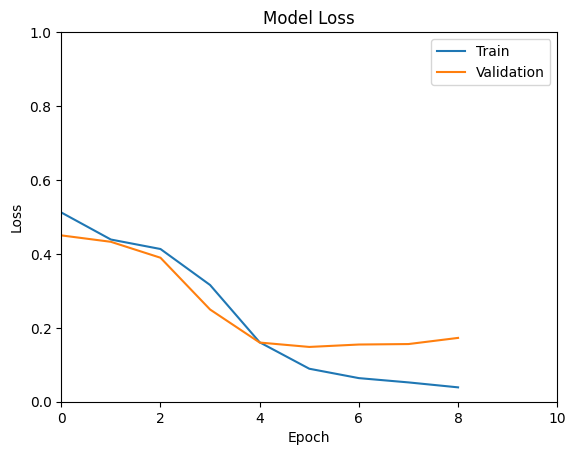

In [107]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.ylim(0, 1)
plt.xlim(0, 10)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Show plot
plt.show()

In [108]:
ypred = model.predict(X_test)

155/155 [==============================] - 1s 4ms/step


ValueError: x and y must be the same size

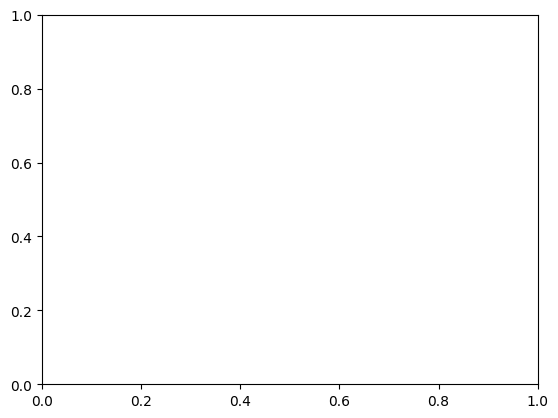

In [109]:
plt.scatter(X_train, y_train, c="black",label="Train")
plt.scatter(X_test, y_test, c="red",label="Test")
plt.plot(X_text,y_pred)
plt.legend()
plt.show()

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

new_data = pd.read_csv("E:\Datasets\English_test.csv")

X_new = new_data["text"]
y_new = new_data["label"]

X_new_seqs = tokenizer.texts_to_sequences(X_new)
X_new_seqs_padded = keras.preprocessing.sequence.pad_sequences(X_new_seqs, maxlen=MAX_REVIEW_LEN)

probabilities_new = model.predict(X_new_seqs_padded)
binary_predictions_new = (probabilities_new >= optimal_threshold).astype(int)

accuracy_new = accuracy_score(y_new, binary_predictions_new)
precision_new = precision_score(y_new, binary_predictions_new)
recall_new = recall_score(y_new, binary_predictions_new)
f1_new = f1_score(y_new, binary_predictions_new)

print("Accuracy on new dataset:", accuracy_new)


185/185 [==============================] - 0s 2ms/step
Accuracy on new dataset: 0.5215035557060617


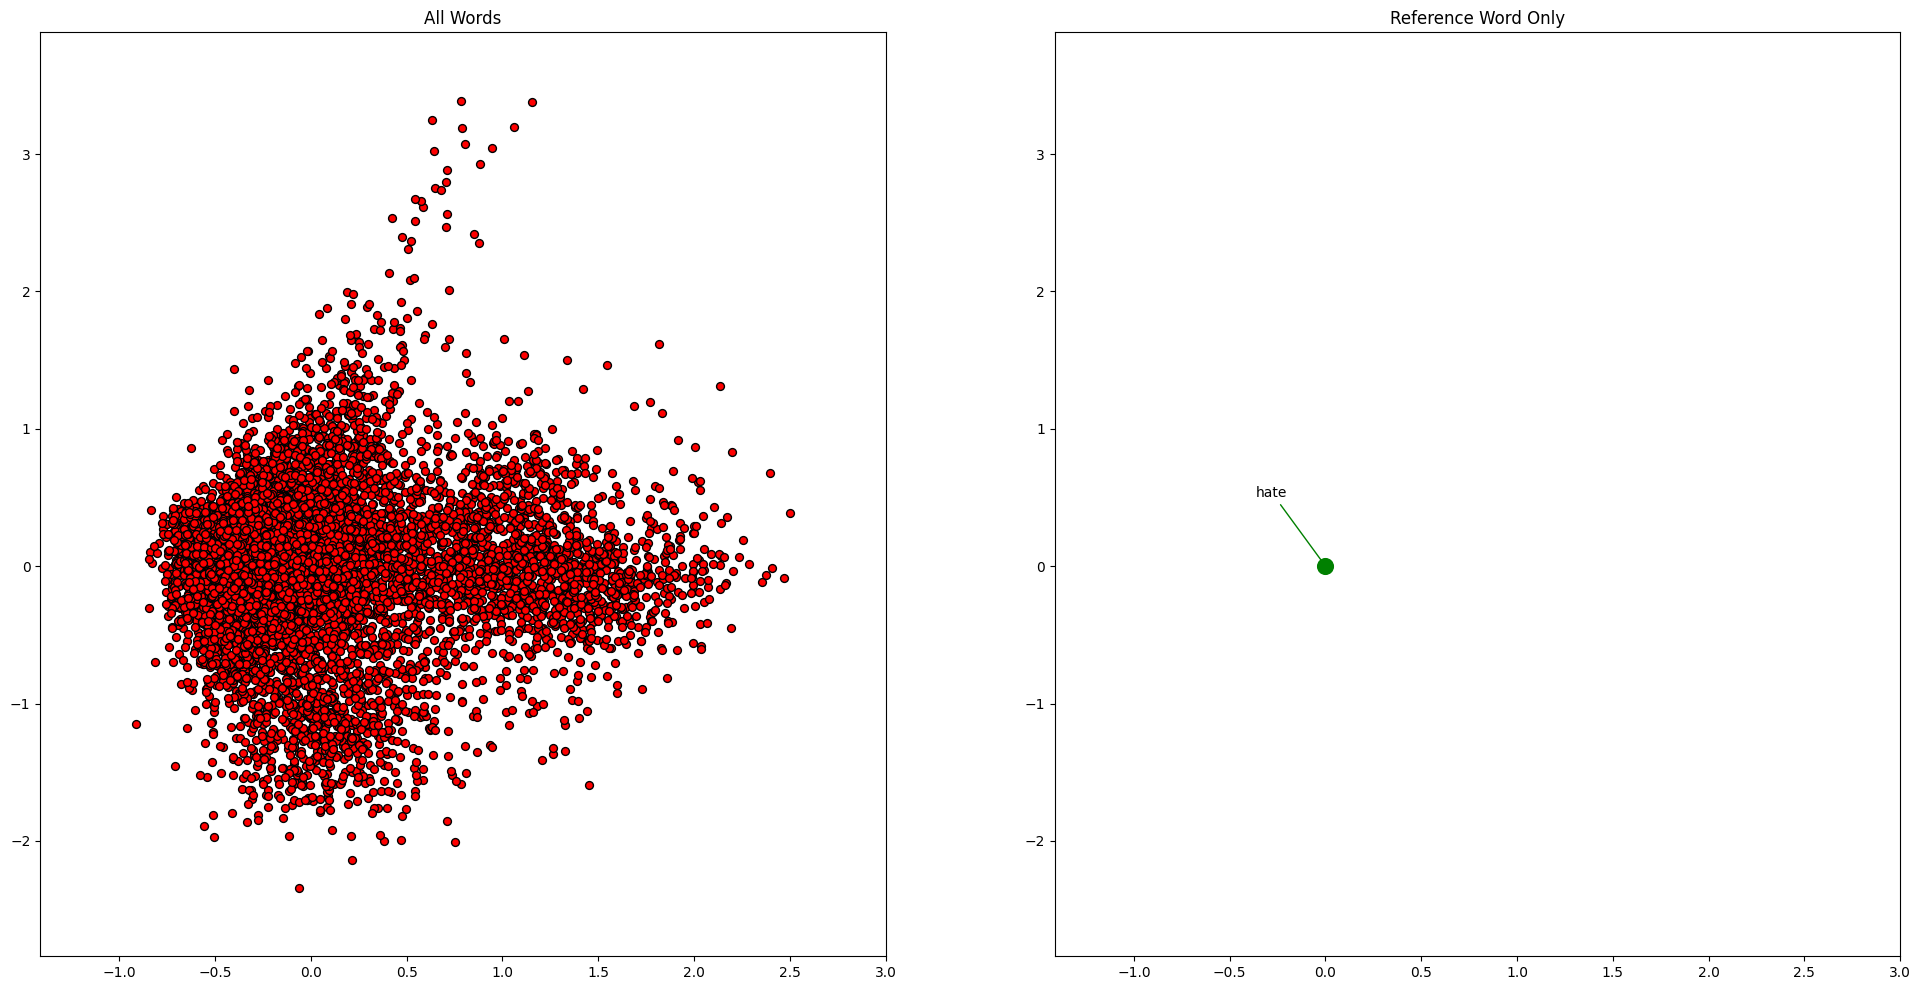

In [57]:
train_unique_words_set = set()
new_data['text'].apply(lambda x: train_unique_words_set.update(get_unique_words(x)))


train_unique_words_list = list(train_unique_words_set)
display_pca_scatterplot(word_vectors, train_unique_words_list)

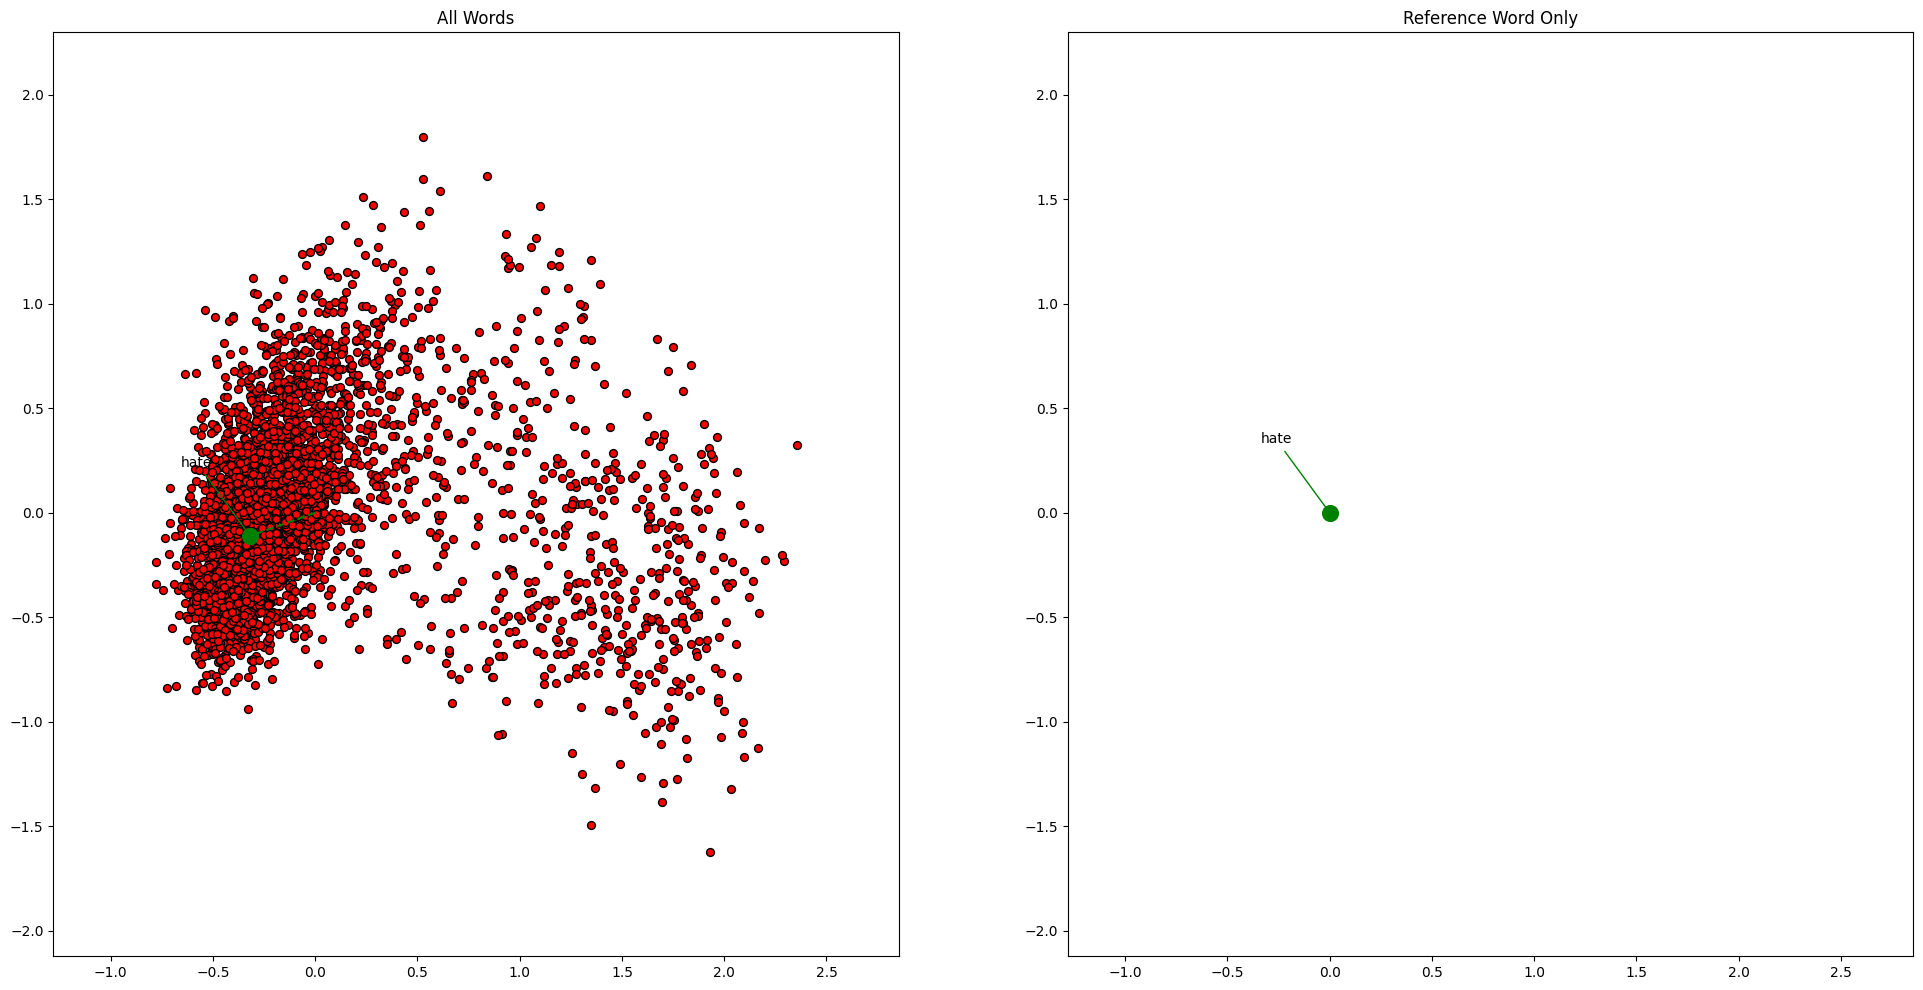

In [61]:
intersection_words_list = list(set(unique_words_list) & set(train_unique_words_list))

if intersection_words_list:
    display_pca_scatterplot(word_vectors, intersection_words_list)
else:
    print("No common words found between unique_words_list and train_unique_words_list.")
